In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def image_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(15, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

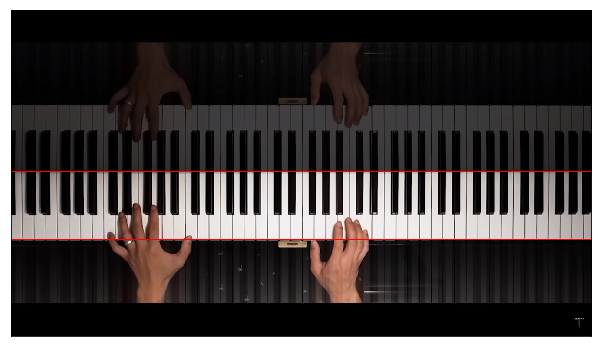

In [3]:
image = cv2.imread("piano1.png")
(h, w, c) = image.shape

# Marcar corte
hi, hf = 548, 804
hi, hf = 535, 760
cropped_preview = image.copy()
cv2.line(cropped_preview, (0, hi), (w-1, hi), (0, 0, 255), 3)
cv2.line(cropped_preview, (0, hf), (w-1, hf), (0, 0, 255), 3)

image_plot(cv2.cvtColor(cropped_preview, cv2.COLOR_BGR2RGB))

cropped = image[hi:hf,:,:]

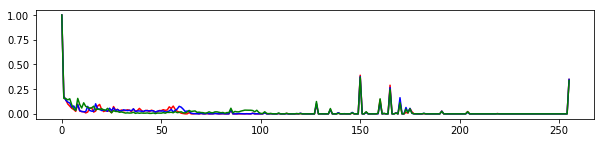

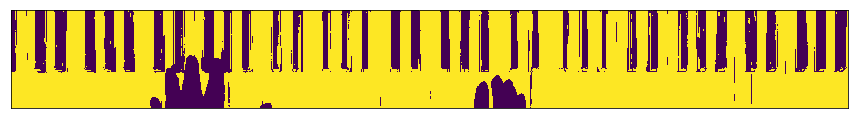

In [4]:
hls_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2HSV)

H_hist = cv2.calcHist(hls_cropped, [0], None, [256], [0, 256])
L_hist = cv2.calcHist(hls_cropped, [1], None, [256], [0, 256])
S_hist = cv2.calcHist(hls_cropped, [2], None, [256], [0, 256])

fig, axes = plt.subplots(1, 1, figsize=(10, 2), sharex=True, sharey=True)
axes.plot(H_hist.ravel() / H_hist.max(), color="r", label="H")
axes.plot(L_hist.ravel() / L_hist.max(), color="b", label="L")
axes.plot(S_hist.ravel() / S_hist.max(), color="g", label="S")
plt.show()

bkeys = np.zeros(hls_cropped[:,:,0].shape).astype('float32')
#bkeys[np.all([hls_cropped[:,:,1] <= 110, hls_cropped[:,:,2] <= 130], axis=0)] = 1.0
bkeys[hls_cropped[:,:,1] <= 50] = 1.0
image_plot((bkeys * 255).astype('uint8'))

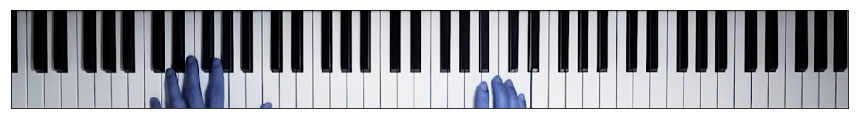

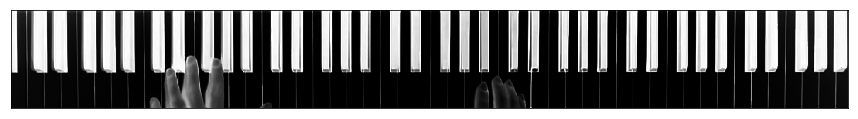

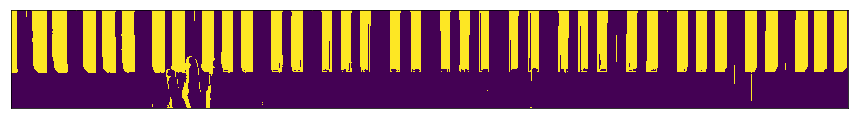

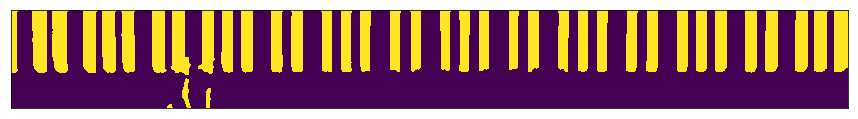

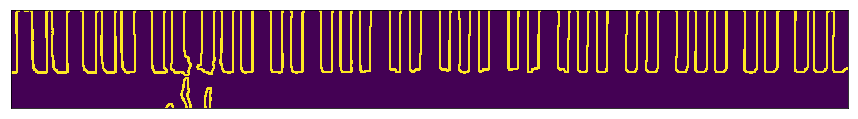

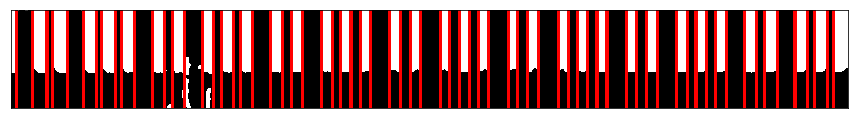

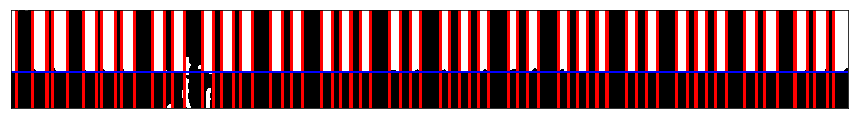

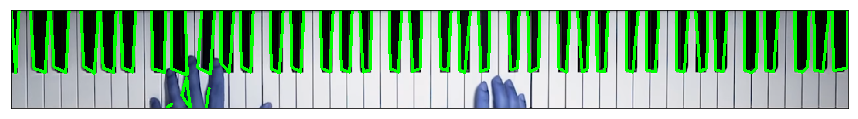

In [18]:
image_plot(cropped)

test = (255 - cropped).prod(axis=2).astype('float32')
test = ((test * 255) / test.max()).astype('uint8')

image_plot(cv2.cvtColor(test, cv2.COLOR_GRAY2RGB))

ret, thresh = cv2.threshold(test, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
image_plot(thresh)
kernel_size = int(cropped.shape[1] * 0.005)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
image_plot(thresh)

edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
# edges = cv2.dilate(thresh, np.ones((5,5))) - thresh
image_plot(cv2.dilate(edges, np.ones((5,5))))


maxsize = int(np.sqrt(cropped.shape[0] ** 2 + cropped.shape[1] ** 2))


hough = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
lines = cv2.HoughLines(edges, 1, np.pi / 32, int(cropped.shape[0] * 0.25))
if lines is not None:
    for line in lines:
        rho, theta = line[0]

        if (np.pi * 3/4 >= (theta % np.pi) >= np.pi * 1/4):
            continue

        a = np.cos(theta)
        b = np.sin(theta)

        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + maxsize * (-b))
        y1 = int(y0 + maxsize * (a))
        x2 = int(x0 - maxsize * (-b))
        y2 = int(y0 - maxsize * (a))

        cv2.line(hough, (x1, y1), (x2, y2), (255, 0, 0), 5)

image_plot(hough)


# hough = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
lines = cv2.HoughLines(edges, 1, np.pi / 4, int(cropped.shape[1] * 0.1))
if lines is not None:
    for line in lines:
        rho, theta = line[0]

        if not (np.pi * 3/4 >= (theta % np.pi) >= np.pi * 1/4):
            continue

        a = np.cos(theta)
        b = np.sin(theta)

        x0 = a * rho
        y0 = b * rho

        x1 = int(x0 + maxsize * (-b))
        y1 = int(y0 + maxsize * (a))
        x2 = int(x0 - maxsize * (-b))
        y2 = int(y0 - maxsize * (a))

        cv2.line(hough, (x1, y1), (x2, y2), (0, 0, 255), 3)

image_plot(hough)

quero = cropped.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    #approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True)
    approx = cv2.approxPolyDP(cnt, 10, True)
    xi,yi,wi,hi = cv2.boundingRect(cnt)
    #cv2.rectangle(quero, (xi,yi), (xi+wi,yi+hi), (0,0,255), 5)
    cv2.drawContours(quero, [approx], 0, (0,255,0), 5)
    
image_plot(quero)


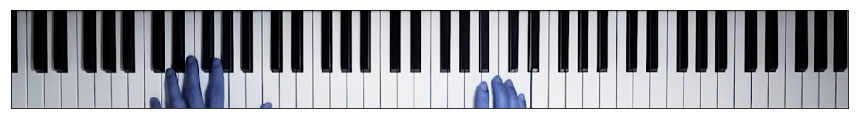

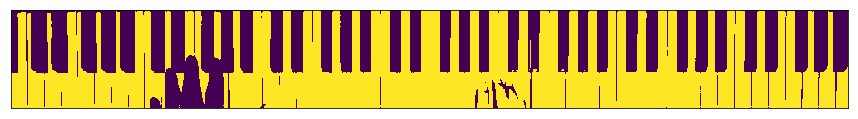

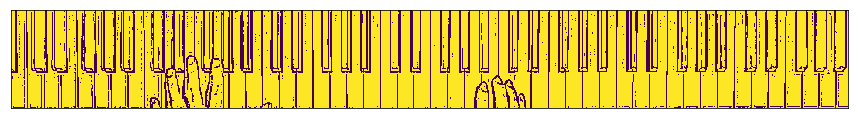

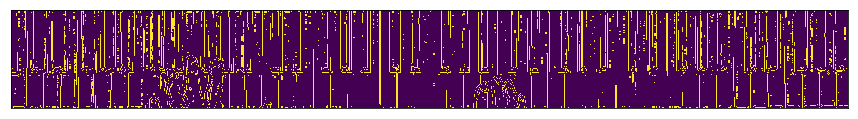

In [17]:
image_plot(cropped)

grayscale = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

# Binarizar
ret, thresh = cv2.threshold(grayscale, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
image_plot(thresh)
thresh = cv2.adaptiveThreshold(grayscale, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
image_plot(thresh)

# Bordas
edges = cv2.Canny(thresh, 200, 300)
image_plot(edges)

In [7]:
# Ransac